# Advanced: Extending the Control Network

In [1]:
import math
import os
import sys

sys.path.insert(0, os.path.abspath('/data/autocnet'))

import autocnet
# Enable the GPU
autocnet.cuda(enable=True)

from autocnet import CandidateGraph

# The GPU based extraction library that contains SIFT extraction and matching
import cudasift as cs
# A method to resize the images on the fly.
from scipy.misc import imresize

%pylab inline
figsize(16,4)

Populating the interactive namespace from numpy and matplotlib


## The CandidateGraph

<img align="right" src="https://camo.githubusercontent.com/09d4e9d8264ac54629d8de5a46f8ff338f3b4629/68747470733a2f2f7261772e6769746875622e636f6d2f7a6174732f566f6c74726f6e2f6d61737465722f566f74726f6e2e6a7067">
Up until this point, the syntax sugar on the candidate graph has not been being used.  This is because it was necessary to play around with the data and explore some constraints on the matching process.  The candidate graph is easier to utilize for the non-developer as the matching process can be distilled down into a single call.  This notebook illustrates how to take the previously explored constraints and add a custom processing method to the graph that can then be applied to any number of nodes and edges.

Basically, we are going for some Voltron extensibility.

The first step is what we have been doing all along, create the CandidateGraph.  Then we have to define a function that is going to do the processing.


In [2]:
# Create the candidate graph and enable a GPU
a = 'AS15-P-0111_CENTER_LRG_CROPPED.png'
b = 'AS15-P-0112_CENTER_LRG_CROPPED.png'

adj = {a:[b],
       b:[a]}

cg = CandidateGraph.from_adjacency(adj)


## Extraction
Extraction is a function of an individual image.  For this reason, extraction is a method of a node within the candidate graph.  We can [monkey patch](https://en.wikipedia.org/wiki/Monkey_patch) the custom method onto the node for easy access by a user.

In [3]:
# Define a function to do the feature extraction.

def extract_features(self, arr, downsample_amount=None, **kwargs):
    total_size = arr.shape[0] * arr.shape[1]
    if not downsample_amount:
        downsample_amount = math.ceil(total_size / 12500**2)
    shape = (int(arr.shape[0] / downsample_amount), int(arr.shape[1] / downsample_amount))
    # Downsample
    arr = imresize(arr, shape, interp='lanczos')
    
    npts = max(arr.shape) / 3.5
    sd = cs.PySiftData(npts)
    cs.ExtractKeypoints(arr, sd, **kwargs)
    kp, des = sd.to_data_frame()
    kp = kp[['x', 'y', 'scale', 'sharpness', 'edgeness', 'orientation', 'score', 'ambiguity']]
    kp['score'] = 0.0
    kp['ambiguity'] = 0.0
    
    # Match the interface defined in the edge.
    self.keypoints = kp
    self.descriptors = des
    
    self['downsample_amount'] = downsample_amount

# Import the class and update it.  This updates the current instance of the CandidateGraph
from autocnet.graph.node import Node
Node.extract_features = extract_features

In [4]:
# Now use the custom method on all nodes in the graph


Now inspect the nodes to confirm that the custom extraction has worked.  The above code added a new attribute to the nodes (`downsample_amount`) into the attribute dictionary.  Below, all of the nodes in the graph are being iterated over.  An arbitraty counter, the downsample amount and the first three keypoints are all being identified.

In [5]:
for i, n in cg.nodes_iter(data=True):  # Iterate over the nodes
    print(i, n['downsample_amount'])
    print(i, n.keypoints.head(3))

0 5
0              x           y      scale  sharpness  edgeness  orientation  \
0  1774.598022  121.213448  18.561510   1.201419  4.345379   246.957138   
1  9224.547852   27.631443  17.625086   6.080946  7.071729   271.284637   
2  9599.548828   28.775124  18.266846   5.637305  7.289649   269.853271   

   score  ambiguity  
0    0.0        0.0  
1    0.0        0.0  
2    0.0        0.0  
1 5
1              x           y      scale  sharpness  edgeness  orientation  \
0  7368.450684   29.992844  22.463808   4.583405  8.915862   270.224182   
1  1236.768066  198.876312  23.577526  -1.066924  4.799350   358.493378   
2  7693.954590   30.541229  21.110060   3.312886  9.297206   270.888702   

   score  ambiguity  
0    0.0        0.0  
1    0.0        0.0  
2    0.0        0.0  


## Why do this?

The above example demonstrates how to take the exploratory analysis that occurred in previous notebooks and aggregate it into the CandidateGraph.  Making the assumption that the CandidateGraph is both the data model and controller (so a combined Model-Controller), it is then possible to create views (the user side application if you will) seamlessly.

The key requirement is that the minimal interface defined by the CandidateGraph be adhered to.

Below, the graph plotting functionality is used - without having to do anything custom.  The graph is acting exactly how we would expect it to.  The difference is that we have injected the logic to work on downsampled images.  Everything else is super vanilla.

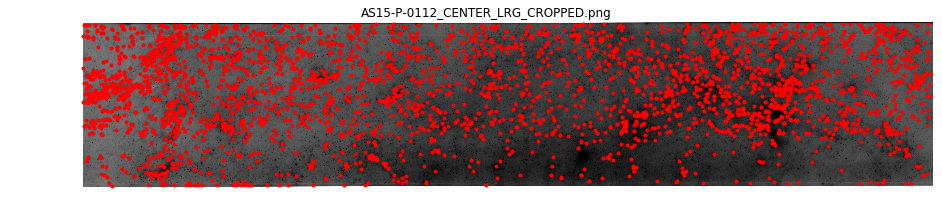

In [6]:
cg.node[0].plot(downsampling=cg.node[0]['downsample_amount'])

## Matching

The next processing step that will require the image array data is subpixel matching.  Therefore, it is possible to continue to use the standard API calls to perform matching.

In [7]:
# Apply matching on all edges
cg.match()

# Check the output
cg.edge[0][1].matches.head(5)

,source_image,source_idx,destination_image,destination_idx,score,ambiguity
0,0.0,0,1.0,32,0.807713,0.927260
1,0.0,1,1.0,13,0.986384,0.997687
2,0.0,2,1.0,36,0.989343,0.998851
3,0.0,3,1.0,276,0.952884,0.893658
4,0.0,4,1.0,102,0.847034,0.981977


## Masks

AutoCNet uses the concept of masks to winnow the possible matches.  The general concept is that all extracted keypoints and matches are of value, whether they are considered to be noise or valid data points.  The decision as to which correspondences are good is also subject to change based on any number of factors (the user decides to accept more error in some region where a correspondence is absolutely required, the density in some region is too high and so valid correspondences are to be ignored, etc.).

Every edge carries a `masks` DataFrame that contains boolean columns to identify which correspondences are valid.  In the below example, the `ambiguity` metric from the CUDA matching process is being stored as the `ratio` column.  Below, that mask will be updated based on the distribution of the data and the score mask will be added.

In [8]:
cg.edge[0][1].masks.head(3)

,ratio
0,False
1,False
2,False


In [11]:
# Iterate over all of the edges in the graph and update the mask attribute based on the distribution of ambiguity and score
for s,d,e in cg.edges_iter(data=True):
    e.masks['ratio'] = e.matches.ambiguity <= e.matches.ambiguity.quantile(0.015)
    e.masks['score'] = e.matches.score >= e.matches.score.quantile(0.85)
    
cg.edge[0][1].masks.head(3)

,ratio,score
0,False,False
1,False,True
2,False,True


## More Masks
Here we plot some results using the `clean_keys` argument.  This argument is used throughout the AutoCNet library to indicate which masks should be applied to the data before processing.  In the example below if either the `ratio` or `score` are False, the correspondence is omitted.

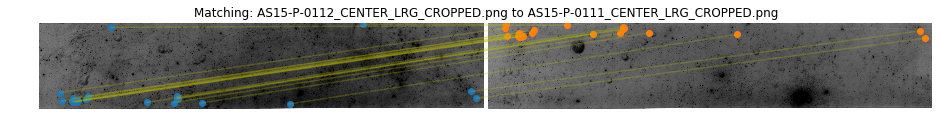

In [12]:
cg.edge[0][1].plot(clean_keys=['ratio', 'score'], downsampling=True, line_kwargs={'alpha':0.25})

## More built-ins

In previous examples, the individual notebook cells were making calls for computation of the fundamental matrix.  Since the custom extractor was patched in, it is possible to just use the syntax sugar calls on the CandidateGraph object.

In [15]:
# Compute the fundamental matrix for all edges
cg.compute_fundamental_matrices(clean_keys=['ratio', 'score'])
# Confirm that a new mask has been added
cg.edge[0][1].masks.head(3)

,ratio,score,fundamental
0,False,False,False
1,False,True,False
2,False,True,False


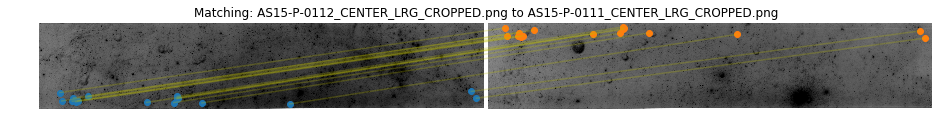

In [16]:
cg.edge[0][1].plot(clean_keys=['fundamental'], downsampling=True, line_kwargs={'alpha':0.25})